In [1]:
import pandas as pd 
import re 
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from collections import Counter 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest

# import the keras library.
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/Users/guapofish/Desktop/mouse_track_data_190_users/page_users/page32.csv')
df = df.rename(columns={"Unnamed: 0": "prolific_id"})
df.set_index(df.columns[0],inplace = True)
df.head()

,num of action,num of delay,numofPt in trajectory,horizontal speed,vertical speed,elapsed time,Average cumulative distance,Avg Curvature,avg moving speed,num of change horizontal
prolific_id,,,,,,,,,,
5b872a3b22f6ff0001f0d2b1,841,27,786,52950.398282,10557.173248,33.646,1013.511978,13.968587,813.315803,653
5e86044a7ed2b904f387bf4c,3542,124,3542,66204.825633,29769.415343,73.115,1835.708301,4.487900,3113.284952,2822
5c3f7c6329966300010dce78,647,16,647,73257.258154,75710.877913,16.546,3489.600953,6.252587,3374.447917,559
5cf62893405986001a14b203,638,34,638,1798.088697,1024.933762,32.975,662.818000,93.661038,683.421134,430
5be57da1f6b5dd0001170bbe,734,40,734,69227.553644,26568.936248,18.203,1628.279767,224.342197,3578.047050,591


# 1. Filter methods

-- Univariate filter methods evaluate and rank a single feature according to certain criteria. <br/>
-- Univariate filter methods evaluate and rank a single feature according to certain criteria.

# 1.1 Quasi-Constant Features

In [3]:
x_train = df 

##### make a threshold for quasi constant.
threshold = 0.5

# create empty list
quasi_constant_feature = []

# loop over all the columns
for feature in x_train.columns:

    # calculate the ratio.
    predominant = (x_train[feature].value_counts() / np.float(len(x_train))).sort_values(ascending=False).values[0]
    
    # append the column name if it is bigger than the threshold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
print(quasi_constant_feature)

# drop the quasi constant columns
x_train.drop(labels=quasi_constant_feature, axis=1, inplace=True)


[]


# 1.2 Correlation Filter Methods

-- Pearson correlation coefficient; Spearman’s rank correlation coefficient; Kendall’s rank correlation coefficient <br/>
-- By default it is the pearson correlation, but it can also be specified as kendall or spearman.

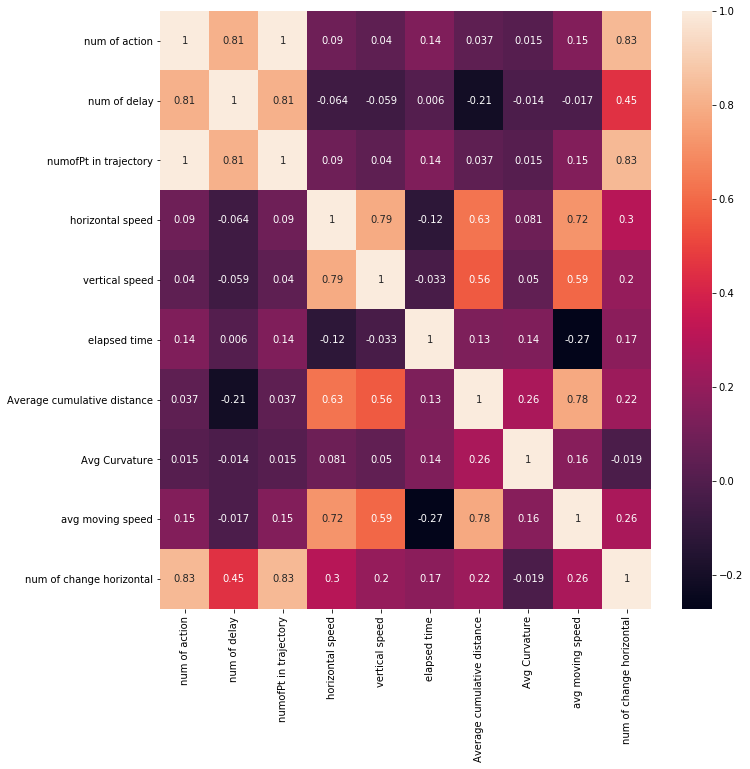

In [4]:
# creating set to hold the correlated features
corr_features = set()

# create the correlation matrix (default to pearson)
corr_matrix = x_train.corr()

# optional: display a heatmap of the correlation matrix
plt.figure(figsize=(11,11))
sns.heatmap(corr_matrix, annot = True)

for i in range(len(corr_matrix .columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
            
x_train.drop(labels=corr_features, axis=1, inplace=True)


# 1.3 Autoencoders for Dimensionality Reduction

In [5]:
x_train = df[:121]
x_test = df[122:]

# the dimension of the encoding layer.
encoding_dim = 9

# create the autoencoder.
model = Sequential()

# add the encoding layer.
model.add(Dense(encoding_dim, activation='relu', input_shape=(x_train.shape[1],)))

# add the output layer.
model.add(Dense(x_train.shape[1], activation='linear'))

# compile the model, you can use whatever optimizer.
model.compile(optimizer='adadelta', loss='categorical_crossentropy')

# fit your model to the training data.
model.fit(x_train, x_train,
                epochs=5,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

# get the first layer weights.
weights = model.layers[1].get_weights()[0]

# get the feature importance.
print(weights.sum(axis = 1))

output_weight = model.layers[1].get_weights()[0].sum(axis = 1)
output_weight

Train on 121 samples, validate on 52 samples
Epoch 1/5
121/121 [==============================] - 0s 1ms/step - loss: 778894.0305 - val_loss: 781395.3125
Epoch 2/5
121/121 [==============================] - 0s 41us/step - loss: 768994.0170 - val_loss: 778414.0625
Epoch 3/5
121/121 [==============================] - 0s 41us/step - loss: 759195.3337 - val_loss: 774669.1250
Epoch 4/5
121/121 [==============================] - 0s 40us/step - loss: 753519.6560 - val_loss: 771006.3750
Epoch 5/5
121/121 [==============================] - 0s 41us/step - loss: 745464.3440 - val_loss: 739228.5625
[ 1.6066521  -0.29452214  0.9697971  -0.47323057 -0.7424825   0.7923951
  1.1057342  -1.3816203   0.35844803]


array([ 1.6066521 , -0.29452214,  0.9697971 , -0.47323057, -0.7424825 ,
        0.7923951 ,  1.1057342 , -1.3816203 ,  0.35844803], dtype=float32)

In [6]:
df.columns[np.argmin(abs(output_weight))]
#not that small, do not throw this feature

'num of delay'

# 2. K-means Algorithm 

# 2.1: standardizing the data using StandardScaler

In [7]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8
count,1.740000e+02,1.740000e+02,1.740000e+02,1.740000e+02,1.740000e+02,1.740000e+02,1.740000e+02,1.740000e+02,1.740000e+02
mean,-9.570888e-18,-7.975740e-18,-5.551115e-17,-1.435633e-17,-2.935072e-17,-6.508204e-17,8.932829e-18,7.656711e-18,9.443276e-17
std,1.002886e+00,1.002886e+00,1.002886e+00,1.002886e+00,1.002886e+00,1.002886e+00,1.002886e+00,1.002886e+00,1.002886e+00
min,-9.072926e-01,-2.202637e-01,-9.055518e-01,-8.320838e-01,-1.121892e+00,-1.096559e+00,-3.236870e-01,-1.062770e+00,-1.493136e+00
25%,-2.908325e-01,-2.105029e-01,-8.674568e-01,-7.993257e-01,-6.538695e-01,-7.223798e-01,-3.038986e-01,-7.650916e-01,-3.490085e-01
50%,-1.479667e-01,-1.958616e-01,-3.411290e-01,-4.045887e-01,-2.944066e-01,-3.812549e-01,-2.447937e-01,-4.228042e-01,-3.511263e-02
75%,-5.663427e-03,-1.629189e-01,6.581676e-01,4.493168e-01,2.853455e-01,7.094876e-01,-4.088449e-02,5.245962e-01,2.139569e-01
max,1.106756e+01,8.930511e+00,3.661830e+00,3.752639e+00,5.620889e+00,4.175790e+00,1.181517e+01,4.844661e+00,7.170846e+00


Elbow method:

Text(0, 0.5, 'Inertia')

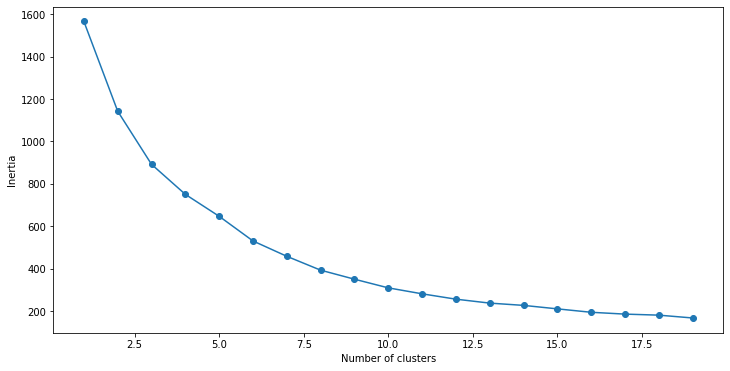

In [8]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [9]:
# k means using 3 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++',max_iter=300, n_init=10, random_state=0)
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

0    106
1     67
2      1
Name: cluster, dtype: int64

In [10]:
idx = frame['cluster'].value_counts().argmin()
cluster_num = frame['cluster'].value_counts().index[idx]
outliner_df = frame[frame['cluster'] == cluster_num]
l_kmeans_scaled = list(df.index[outliner_df.index])

# 2.2: adding PCA for dimension reduction

In [11]:
pca = PCA(3) 
pca.fit(df) 
  
pca_data = pd.DataFrame(pca.transform(df)) 
pca_data.head()

,0,1,2
0,8635.790067,-15348.843416,-2259.826248
1,29173.893030,-4147.036862,-1226.609288
2,56097.575725,33782.078878,-713.248945
3,-41336.283288,-945.403424,-632.704942
4,30435.107187,-8347.135831,-1316.091358


Text(0, 0.5, 'Inertia')

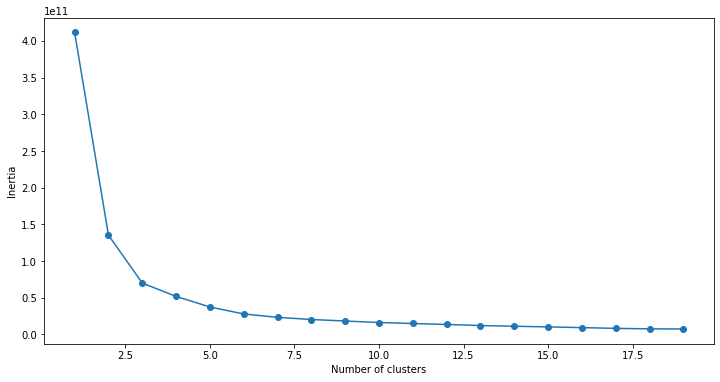

In [12]:
#elbow method:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++',
                    max_iter=300, n_init=10, random_state=0).fit(pca_data)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting the elbow
frame2 = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame2['Cluster'], frame2['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [13]:
kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++',max_iter=300, n_init=10, random_state=0)
#k-means++ ensures that you get don’t fall into the random initialization trap.
kmeans.fit(pca_data)
pred = kmeans.predict(pca_data)

pca_data['cluster'] = pred
pca_data['cluster'].value_counts()

1    89
0    61
2    24
Name: cluster, dtype: int64

In [14]:
idx = pca_data['cluster'].value_counts().argmin()
cluster_num = pca_data['cluster'].value_counts().index[idx]
outliner_pca_df = pca_data[pca_data['cluster'] == cluster_num]
l_kmeansPca = list(df.index[outliner_pca_df.index])

#compare l_kmeans_scaled and l_kmeansPca:
l_kmeans_scaled, l_kmeansPca

(['5c24e83ac298750001776310'],
 ['5c3f7c6329966300010dce78',
  '5e2712e1f1fa1b9422ea194a',
  '5e93301515768a1680c9705a',
  '5c9cb670b472d0001295f377',
  '5e8b0faa3d71b07b69ef26f4',
  '5d46db7698512400018c1c52',
  '5d20d61a7afc290015e5a7a5',
  '5c4266e71fad93000122d5cf',
  '5aea56160335e200019ea543',
  '5ae9a58f41193b0001fd40fe',
  '5e91128ddf10df4440f6243f',
  '5dbc534dcc227d1f37845307',
  '5e0fa7a85005cc6c6348dc8a',
  '587905adc34844000174ee45',
  '5d8aa1e3eab19600163d9ab7',
  '5e89eebae770eb68ac82c705',
  '5b9783b4e189b0000188e956',
  '5a25c8a96267fa00016e3fb4',
  '5df2235d5a34251266ea645e',
  '5e33927476397a369848edf8',
  '5e2a0c147554ec075dcd5030',
  '5d5047590ea65a001adcec9f',
  '5de4280370c53a011839950f',
  '5c02b1bad84faa0001489709'])

Conclusion: The results of cell [10] have some overlap ids, we might add the em algorithm for kmeans algo in the future, but so far we want to introduce another beautiful algorithm to detect the outliner which is the Isolation Forest Algorithm 

# 2.3 mutally select pairs based on the lowest inertia:

In [15]:
def get_npair_2DKmeans(n):    

    range_num = len(df.columns)
    combo = list(itertools.combinations(range(range_num), 2))
    kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
    inertia = []

    for item in combo:
        data = pd.DataFrame(data_scaled)[[item[0],item[1]]]  
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    l_sort = sorted(inertia, reverse=False)
    outputPair = []
    km = []
    
    for i in range(n):
        c = combo[inertia.index(l_sort[i])]
        outputPair.append([df.columns[c[0]],df.columns[c[1]]])     
        
        f = pd.DataFrame(data_scaled)[[c[0],c[1]]]     
        kmean = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
        kmean.fit(f)
        pred = kmean.predict(f)
        
        f['cluster'] = pred      
        idx = f['cluster'].value_counts().argmin()
        cluster_num = f['cluster'].value_counts().index[idx]
        outliner_df = f[f['cluster'] == cluster_num]
        km = km + list(df.index[outliner_df.index])
        
    return outputPair,km

def get_npair_3DKmeans(n):

    range_num = len(df.columns)
    combo = list(itertools.combinations(range(range_num), 3))
    kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
    inertia = []

    for item in combo:
        data = pd.DataFrame(data_scaled)[[item[0],item[1],item[2]]]  
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    l_sort = sorted(inertia, reverse=False)
    outputPair = []
    km = []
    
    for i in range(n):
        c = combo[inertia.index(l_sort[i])]
        outputPair.append([df.columns[c[0]],df.columns[c[1]],df.columns[c[2]]])     
        
        f = pd.DataFrame(data_scaled)[[c[0],c[1],c[2]]]     
        kmean = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
        kmean.fit(f)
        pred = kmean.predict(f)
        
        f['cluster'] = pred      
        idx = f['cluster'].value_counts().argmin()
        cluster_num = f['cluster'].value_counts().index[idx]
        outliner_df = f[f['cluster'] == cluster_num]
        km = km + list(df.index[outliner_df.index])
        
    return outputPair,km

In [16]:
outputPair2D, l_K_means2D_outlier = get_npair_2DKmeans(5)
outputPair3D, l_K_means3D_outlier = get_npair_3DKmeans(5)

#set(l_K_means2D_outlier).difference(set(l_K_means3D_outlier_user)); length = 7
counter_mutualPair = Counter(l_K_means2D_outlier+l_K_means3D_outlier)
counter_mutualPair

Counter({'5c24e83ac298750001776310': 6,
         '5be0662dea836b0001e9870f': 2,
         '5c3f7c6329966300010dce78': 2,
         '5e2712e1f1fa1b9422ea194a': 2,
         '5e93301515768a1680c9705a': 2,
         '5c3ce3a6de04ad0001d8a6cc': 2,
         '5c9cb670b472d0001295f377': 2,
         '5d46db7698512400018c1c52': 2,
         '5d20d61a7afc290015e5a7a5': 2,
         '5c4266e71fad93000122d5cf': 2,
         '5aea56160335e200019ea543': 2,
         '5bd6f3369c5d1f000195e70c': 2,
         '5ae9a58f41193b0001fd40fe': 2,
         '5e91128ddf10df4440f6243f': 2,
         '5dbc534dcc227d1f37845307': 2,
         '5e0fa7a85005cc6c6348dc8a': 2,
         '587905adc34844000174ee45': 2,
         '5d8aa1e3eab19600163d9ab7': 2,
         '5e89eebae770eb68ac82c705': 2,
         '5b9783b4e189b0000188e956': 2,
         '5a25c8a96267fa00016e3fb4': 2,
         '5df2235d5a34251266ea645e': 2,
         '5e33927476397a369848edf8': 2,
         '5e2a0c147554ec075dcd5030': 2,
         '5d5047590ea65a001adcec9f': 2,


# 3. Isolation Forest Algorithm

Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

Using Isolation Forest, we can not only detect anomalies faster but we also require less memory compared to other algorithms.

In [17]:
def isolation_Forest_Algo(df):
    
    ##apply an Isolation forest
    model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
    model.fit(df)
    scores =model.decision_function(df)

    outlier_detect = IsolationForest(n_estimators=100, max_samples=1000, contamination=.04, max_features=df.shape[1])
    outlier_detect.fit(df)
    outliers_predicted = outlier_detect.predict(df)

    #check the results
    df['outlier'] = outliers_predicted
    df['scores'] = scores
    
    outliner_iso_forest = list(df[df.outlier != 1].index)
    return outliner_iso_forest,df


In [18]:
l,iso_forest_df = isolation_Forest_Algo(df)
l

/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (1000) is greater than the total number of samples (174). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


['5e86044a7ed2b904f387bf4c',
 '5be0662dea836b0001e9870f',
 '5c24e83ac298750001776310',
 '5e7d2f16e863ba0d96dc610f',
 '5d5a694c3aa59b00010f2c16',
 '5df2235d5a34251266ea645e',
 '5c02b1bad84faa0001489709']